In [601]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import plotly.express as px
import plotly.graph_objects as go

## Import Data

In [ ]:
## Read csv file
df=pd.read_csv("adventure_works_purchase_orders.csv")

#Connect to a database
con = sqlite3.connect("my_db.db")

#Store your table in the database:
df.to_sql('aw_purchase_orders', con)

In [3]:
df

,SalesOrderNumber,OrderDate,DueDate,ShipDate,Sales_Person,Sales_Region,Sales_Province,Sales_City,Sales_Postal_Code,Customer_Code,...,LineItem_Id,Product_Category,Product_Sub_Category,Product_Name,Product_Code,Unit_Cost,UnitPrice,UnitPriceDiscount,OrderQty,Unit_Freight_Cost
0,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,1,Bikes,Mountain Bikes,"Mountain-100 Black, 42",BK-M82B-42,1898.094400,3374.99,0.0,1,51.3415
1,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,2,Bikes,Mountain Bikes,"Mountain-100 Black, 44",BK-M82B-44,1898.094400,3374.99,0.0,3,51.3415
2,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,3,Bikes,Mountain Bikes,"Mountain-100 Black, 48",BK-M82B-48,1898.094400,3374.99,0.0,1,51.3415
3,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,4,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",BK-M82S-38,1912.154400,3399.99,0.0,1,51.3415
4,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,5,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",BK-M82S-42,1912.154400,3399.99,0.0,1,51.3415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41879,SO71952,6/1/08,00:00.0,00:00.0,Michael Blythe,United States,Michigan,Detroit,48226,AW00030046,...,113559,Components,Mountain Frames,"LL Mountain Frame - Silver, 52",FR-M21S-52,180.742250,264.05,0.0,2,50.0991
41880,SO71952,6/1/08,00:00.0,00:00.0,Michael Blythe,United States,Michigan,Detroit,48226,AW00030046,...,113560,Components,Mountain Frames,"HL Mountain Frame - Black, 42",FR-M94B-42,923.801250,1349.60,0.0,1,50.0991
41881,SO71952,6/1/08,00:00.0,00:00.0,Michael Blythe,United States,Michigan,Detroit,48226,AW00030046,...,113561,Components,Mountain Frames,"HL Mountain Frame - Silver, 46",FR-M94S-46,934.000250,1364.50,0.0,4,50.0991
41882,SO71952,6/1/08,00:00.0,00:00.0,Michael Blythe,United States,Michigan,Detroit,48226,AW00030046,...,113562,Components,Bottom Brackets,LL Bottom Bracket,BB-7421,29.964500,53.99,0.0,3,50.0991


## Data Validation

### Data-type check

In [52]:
## Order Date will be converted into 2 a 'month with year' value

df.dtypes

SalesOrderNumber         object
OrderDate                object
DueDate                  object
ShipDate                 object
Sales_Person             object
Sales_Region             object
Sales_Province           object
Sales_City               object
Sales_Postal_Code        object
Customer_Code            object
Customer_Name            object
Customer_Region          object
Customer_Province        object
Customer_City            object
Customer_Postal_Code     object
LineItem_Id              object
Product_Category         object
Product_Sub_Category     object
Product_Name             object
Product_Code             object
Unit_Cost               float64
UnitPrice               float64
UnitPriceDiscount       float64
OrderQty                  int64
Unit_Freight_Cost       float64
dtype: object

In [ ]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

### Logic Check

In [415]:
## Checked directly in the csv file:
   ## No blank rows
   ## No null values
   ## Each order is unique to a date, sales person, postal code, province, region and customer
   ## Each postal code is unique to a city, province and region combination
   ## Each customer code is unique to a customer name in a postal code
   ## Each product is allocated to only one subcategory within a category

## Is LineItem_id my key?

query = """

SELECT count (distinct LineItem_Id)/count (*) as if_1_then_key
FROM aw_purchase_orders a

"""

data=pd.read_sql_query(sql=query,con=con)
df1=pd.DataFrame(data=data)
df1

,if_1_then_key
0,1


### Values Check

In [416]:
## The Unit Price Should not be lower than the Unit Price
## Discount should be between 0 and 1
## Price with Discount should not be lower than the unit cost
## Freight Cost Check

query = """

SELECT count (*) as rows
    , sum (case when (UnitPrice - Unit_Cost) < 0 then 1 else 0 end) as margin_negative
    , sum (case when (unitpricediscount < 0 OR unitpricediscount > 1) then 1 else 0 end) as discount_odd_values
    , sum (case when (UnitPrice-unitpricediscount-Unit_Cost) < 0 then 1 else 0 end) as margin_negative_with_discount
    , sum (case when (UnitPrice-unitpricediscount-Unit_Cost-Unit_Freight_Cost) < 0 then 1 else 0 end) as negative_profit_with_discount
    , sum (case when (UnitPrice-Unit_Cost-Unit_Freight_Cost) < 0 then 1 else 0 end) as negative_profit_with_costs
    , sum (case when (UnitPrice-Unit_Freight_Cost) < 0 then 1 else 0 end) as negative_profit
    
FROM aw_purchase_orders a

"""

data=pd.read_sql_query(sql=query,con=con)
df11=pd.DataFrame(data=data)
df11

,rows,margin_negative,discount_odd_values,margin_negative_with_discount,negative_profit_with_discount,negative_profit_with_costs,negative_profit
0,41884,0,0,0,9780,9779,4948


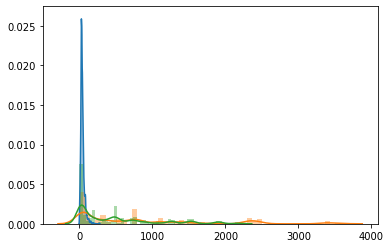

In [417]:
## Distribution of price and costs

fc = pd.read_sql_query(sql=""" SELECT Unit_Freight_Cost FROM aw_purchase_orders """,con=con)
up = pd.read_sql_query(sql=""" SELECT UnitPrice         FROM aw_purchase_orders """,con=con)
uc = pd.read_sql_query(sql=""" SELECT Unit_Cost         FROM aw_purchase_orders """,con=con)

sns.distplot(fc)
sns.distplot(up)
sns.distplot(uc)

## Results Overview

#### Prepare Data

In [598]:
query = """

with customer as
(
    SELECT Customer_Name 
        , min(orderdate) as first_order 
        , LineItem_Id 
    FROM aw_purchase_orders
    GROUP BY 1
)

    SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        
        , count(distinct a.SalesOrderNumber) as orders
        , sum(a.orderqty) as sold_items    
        
        , sum(case when c.customer_name is not null then 1 else 0 end) as new_customers
        
        , sum(a.orderqty * a.unitprice) as gmv_bef_discount
        
        , sum(a.orderqty * a.unitprice * unitpricediscount) as gmv_discount        
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        , sum(Unit_Freight_Cost * a.orderqty) as gmv_shipping_cost
  
    FROM aw_purchase_orders a
    LEFT JOIN customer c ON c.Customer_Name = a.Customer_Name 
                            and c.LineItem_Id = a.LineItem_Id 

    WHERE a.LineItem_Id <> 95166

    GROUP BY 1

"""

data=pd.read_sql_query(sql=query,con=con)
df2=pd.DataFrame(data=data)
df2

,year_month,orders,sold_items,new_customers,gmv_bef_discount,gmv_discount,gmv_cost,gmv_shipping_cost
0,2005-07,31,594,0,638871.550,0.00000,3.731182e+05,27240.5180
1,2005-08,54,1566,0,2080426.540,2680.16720,1.194329e+06,113769.7028
2,2005-09,48,1236,0,1634332.220,752.94780,9.408952e+05,80640.1931
3,2005-10,33,875,1,1041963.910,17.57500,6.105701e+05,52625.1070
4,2005-11,67,2352,67,3302632.620,1569.85300,1.911949e+06,185718.0509
5,2005-12,53,1808,53,2460980.970,847.25560,1.427575e+06,139793.3188
6,2006-01,33,613,33,933633.850,0.00000,5.456763e+05,43735.7572
7,2006-02,60,1696,0,2754469.890,11.68500,1.601503e+06,144233.5746
8,2006-03,53,1302,3,1903974.680,0.00000,1.107956e+06,92792.7992
9,2006-04,30,886,0,1116136.370,10.83000,6.515870e+05,50996.2572


#### Profit

In [599]:
df3 = df2.groupby(['year_month']).agg({'orders':'sum','sold_items':'sum','new_customers':'sum','gmv_bef_discount':'sum','gmv_discount':'sum','gmv_cost':'sum','gmv_shipping_cost':'sum'}).reset_index()

## Profit Waterfall
df3['gmv_aft_discount']                   = df3['gmv_bef_discount'] - df3['gmv_discount']
df3['gmv_aft_discount_cost']              = df3['gmv_bef_discount'] - df3['gmv_discount'] - df3['gmv_cost']
df3['profit']                             = df3['gmv_bef_discount'] - df3['gmv_cost'] - df3['gmv_shipping_cost'] - df3['gmv_discount']

## Margin
df3['margin']                             = df3['profit']/df3['gmv_bef_discount']
df3['margin_discount']                    = df3['gmv_aft_discount'] / df3['gmv_bef_discount']
df3['margin_unit_cost']                   = (df3['gmv_bef_discount']-df3['gmv_cost'])/df3['gmv_bef_discount']
df3['margin_shipping']                    = (df3['gmv_bef_discount']-df3['gmv_shipping_cost'])/df3['gmv_bef_discount']

## Total Costs
df3['total_costs']                        = df3['gmv_cost'] + df3['gmv_shipping_cost'] + df3['gmv_discount']


In [602]:
## Profit Waterfall

fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_bef_discount,
                    mode='lines+markers',
                    name='GMV before Discount'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_discount,
                    mode='markers',
                    name='Discount'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_aft_discount,
                    mode='lines',
                    name='GMV after Discount'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_cost,
                    mode='markers',
                    name='Unit_costs'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_aft_discount_cost,
                    mode='lines',
                    name='GMV after Discount and Costs'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_shipping_cost,
                    mode='markers',
                    name='Shipping Cost'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.profit,
                    mode='lines+markers',
                    name='Profit'))
fig.show()

In [450]:
## Costs Waterfall

fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.total_costs,
                    mode='lines+markers',
                    name='total_costs'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_discount,
                    mode='lines',
                    name='Discount'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_cost,
                    mode='lines',
                    name='Costs'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.gmv_shipping_cost,
                    mode='lines',
                    name='Shipping Cost'))

fig.show()

In [603]:
## Margin Waterfall
  
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.margin,
                    mode='lines+markers',
                    name='margin'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.margin_discount,
                    mode='lines',
                    name='margin_discount'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.margin_unit_cost,
                    mode='lines',
                    name='margin_unit_cost'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.margin_shipping,
                    mode='lines',
                    name='margin_shipping'))
fig.show()

#### Orders, New Customers and Sold Items Evolution

In [452]:
## Order Composition
df3['avg_items_order']                    = df3['sold_items']/df3['orders'] 
df3['avg_order_value']                    = df3['gmv_aft_discount']/df3['orders']
df3['avg_order_profit']                   = df3['profit']/df3['orders']

In [453]:
## Orders and New Customers
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.orders,
                    mode='lines',
                    name='Orders'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.new_customers,
                    mode='lines',
                    name='New Customers'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_items_order,
                    mode='markers',
                    name='avg_items_per_order'))
fig.show()


In [458]:
## Sold Items
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_order_value,
                    mode='lines+markers',
                    name='avg_order_value'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_order_profit,
                    mode='lines+markers',
                    name='avg_order_profit'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.sold_items,
                    mode='lines+markers',
                    name='sold_items'))
fig.show()

#### Sold Items Price Structure

In [494]:
## Price Structure
df3['avg_item_price']                     = df3['gmv_bef_discount']/df3['sold_items'] 
df3['avg_item_cost']                      = df3['gmv_cost']/df3['sold_items'] 
df3['avg_item_margin']                    = (df3['avg_item_price'] - df3['avg_item_cost'])/df3['avg_item_price']

In [495]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_item_price,
                    mode='lines',
                    name='avg_item_price'))
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_item_cost,
                    mode='lines',
                    name='avg_item_cost'))
fig.show()

In [475]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3.year_month, y=df3.avg_item_margin,
                    mode='lines',
                    name='avg_item_margin'))
fig.show()

## Results Deepdive

#### Sold Items Price Structure

In [560]:
query = """

    SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        , Product_Category         
        --, Product_Sub_Category   
        --, Product_Name 
        --, Product_Code 
        , count (distinct SalesOrderNumber) as orders
        , sum(a.orderqty) as sold_items
        , sum(a.unitprice * a.orderqty) as gmv_bef_discount
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        , (sum(a.unitprice * a.orderqty) - sum(a.unit_cost * a.orderqty))/sum(a.unitprice * a.orderqty) as avg_margin_cost
   
    FROM aw_purchase_orders a
    
    WHERE a.LineItem_Id <> 95166

    GROUP BY 1
        , 2
        --, 3
        --, 4
        --, 5
"""

data=pd.read_sql_query(sql=query,con=con)
df4=pd.DataFrame(data=data)
df4


,year_month,Product_Category,orders,sold_items,gmv_bef_discount,gmv_cost,avg_margin_cost
0,2005-07,Accessories,12,69,2414.31,9.029547e+02,0.625999
1,2005-07,Bikes,30,334,602904.02,3.524553e+05,0.415404
2,2005-07,Clothing,19,126,3693.61,2.699088e+03,0.269255
3,2005-07,Components,13,65,29859.61,1.706087e+04,0.428631
4,2005-08,Accessories,23,136,4758.64,1.779737e+03,0.625999
...,...,...,...,...,...,...,...
139,2008-05,Components,89,1796,655062.56,4.568353e+05,0.302608
140,2008-06,Accessories,38,804,32825.20,1.534581e+04,0.532499
141,2008-06,Bikes,85,1858,2783978.30,2.102342e+06,0.244843
142,2008-06,Clothing,68,1563,71024.35,4.836038e+04,0.319101


In [571]:
fig = px.line(df4, x='year_month', y='gmv_bef_discount', color='Product_Category')
fig.show()

fig = px.line(df4, x='year_month', y='sold_items', color='Product_Category')
fig.show()

fig = px.line(df4, x='year_month', y='gmv_cost', color='Product_Category')
fig.show()

fig = px.line(df4, x='year_month', y='orders', color='Product_Category')
fig.show()

In [ ]:
fig = px.scatter(df4, x="year_month", y="avg_margin_cost", color="Product_Category",
                 size='gmv_bef_discount', hover_data=['Product_Category'])
fig.show()

In [562]:
query = """

    SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        , Product_Category         
        , Product_Sub_Category   
        --, Product_Name 
        --, Product_Code 
        , count (distinct SalesOrderNumber) as orders
        , sum(a.orderqty) as sold_items
        , sum(a.unitprice * a.orderqty) as gmv_bef_discount
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        , (sum(a.unitprice * a.orderqty) - sum(a.unit_cost * a.orderqty))/sum(a.unitprice * a.orderqty) as avg_margin_cost
   
    FROM aw_purchase_orders a
    
    WHERE a.LineItem_Id <> 95166
        and Product_Category = 'Bikes'

    GROUP BY 1
        , 2
        , 3
        --, 4
        --, 5
"""

data=pd.read_sql_query(sql=query,con=con)
df5=pd.DataFrame(data=data)
df5

,year_month,Product_Category,Product_Sub_Category,orders,sold_items,gmv_bef_discount,gmv_cost,avg_margin_cost
0,2005-07,Bikes,Mountain Bikes,10,101,341698.99,1.921715e+05,0.437600
1,2005-07,Bikes,Road Bikes,20,233,261205.03,1.602838e+05,0.386368
2,2005-08,Bikes,Mountain Bikes,25,411,1391945.89,7.828304e+05,0.437600
3,2005-08,Bikes,Road Bikes,27,434,505636.90,3.102042e+05,0.386508
4,2005-09,Bikes,Mountain Bikes,21,300,1016322.00,5.715795e+05,0.437600
...,...,...,...,...,...,...,...,...
79,2008-05,Bikes,Road Bikes,37,905,1307668.43,1.040250e+06,0.204500
80,2008-05,Bikes,Touring Bikes,19,547,809865.09,6.292652e+05,0.223000
81,2008-06,Bikes,Mountain Bikes,24,506,814906.44,5.556929e+05,0.318090
82,2008-06,Bikes,Road Bikes,30,658,901629.80,7.172465e+05,0.204500


In [563]:
fig = px.scatter(df5, x="year_month", y="avg_margin_cost", color="Product_Sub_Category",
                 size='gmv_bef_discount', hover_data=['Product_Sub_Category'])
fig.show()

In [567]:
query = """

    SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        , Product_Category         
        , Product_Sub_Category   
        , Product_Name 
        --, Product_Code 
        , count (distinct SalesOrderNumber) as orders
        , sum(a.orderqty) as sold_items
        , sum(a.unitprice * a.orderqty) as gmv_bef_discount
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        , (sum(a.unitprice * a.orderqty) - sum(a.unit_cost * a.orderqty))/sum(a.unitprice * a.orderqty) as avg_margin_cost
   
    FROM aw_purchase_orders a
    
    WHERE a.LineItem_Id <> 95166
        and Product_Category = 'Bikes'

    GROUP BY 1
        , 2
        , 3
        , 4
        --, 5
"""

data=pd.read_sql_query(sql=query,con=con)
df6=pd.DataFrame(data=data)
df6

,year_month,Product_Category,Product_Sub_Category,Product_Name,orders,sold_items,gmv_bef_discount,gmv_cost,avg_margin_cost
0,2005-07,Bikes,Mountain Bikes,"Mountain-100 Black, 38",6,19,64124.81,36063.7936,0.4376
1,2005-07,Bikes,Mountain Bikes,"Mountain-100 Black, 42",6,10,33749.90,18980.9440,0.4376
2,2005-07,Bikes,Mountain Bikes,"Mountain-100 Black, 44",6,21,70874.79,39859.9824,0.4376
3,2005-07,Bikes,Mountain Bikes,"Mountain-100 Black, 48",8,18,60749.82,34165.6992,0.4376
4,2005-07,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",4,10,33999.90,19121.5440,0.4376
...,...,...,...,...,...,...,...,...,...
1474,2008-06,Bikes,Touring Bikes,"Touring-3000 Yellow, 44",18,43,31921.05,24802.6580,0.2230
1475,2008-06,Bikes,Touring Bikes,"Touring-3000 Yellow, 50",14,33,24497.55,19034.5980,0.2230
1476,2008-06,Bikes,Touring Bikes,"Touring-3000 Yellow, 54",12,21,15589.35,12112.9260,0.2230
1477,2008-06,Bikes,Touring Bikes,"Touring-3000 Yellow, 58",6,16,11877.60,9228.8960,0.2230


In [568]:
fig = px.scatter(df6, x="year_month", y="avg_margin_cost", color="Product_Name",
                 size='gmv_bef_discount', hover_data=['Product_Name'])
fig.show()

In [595]:
query = """

    SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        , Sales_Person             
        , Sales_Region            
        , Sales_Province           
        , Sales_City               
        , Sales_Postal_Code        
        , Customer_Code            
        , Customer_Name           
        , Customer_Region          
        , Customer_Province        
        , Customer_City            
        , Customer_Postal_Code     
        , sum(a.unitprice * a.orderqty) as gmv_bef_discount
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        
    FROM aw_purchase_orders a
    
    WHERE a.LineItem_Id <> 95166
        and Product_Category = 'Bikes'

    GROUP BY 1
        , 2
        , 3
        , 4
        , 5
        , 6
        , 7
        , 8
        , 9
        , 10
        , 11
        , 12
"""

data=pd.read_sql_query(sql=query,con=con)
df7=pd.DataFrame(data=data)
df7

,year_month,Sales_Person,Sales_Region,Sales_Province,Sales_City,Sales_Postal_Code,Customer_Code,Customer_Name,Customer_Region,Customer_Province,Customer_City,Customer_Postal_Code,gmv_bef_discount,gmv_cost
0,2005-07,David Campbell,United States,Washington,Bellevue,98004,AW00029497,Great Bikes,United States,Wyoming,Casper,82601,70974.79,39916.222400
1,2005-07,David Campbell,United States,Washington,Bellevue,98004,AW00029580,Latest Sports Equipment,United States,Washington,Seattle,98104,23649.93,13300.720800
2,2005-07,David Campbell,United States,Washington,Bellevue,98004,AW00029606,Fifth Bike Store,United States,Washington,Everett,98201,5939.95,3627.538100
3,2005-07,David Campbell,United States,Washington,Bellevue,98004,AW00029890,Basic Bike Company,United States,Washington,Port Orchard,98366,12650.18,7745.658700
4,2005-07,Jillian Carson,United States,Minnesota,Duluth,55802,AW00029570,Grease and Oil Products Company,United States,Texas,Houston,77003,1457.99,884.708300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,2008-06,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029715,Excellent Riding Supplies,United States,Tennessee,Memphis,38103,126193.52,100386.941250
2195,2008-06,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029721,Bike Goods,United States,Florida,North Miami Beach,33162,2443.35,1943.684875
2196,2008-06,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029762,Quitting Business Distributors,United States,Florida,Tampa,33602,13023.81,10119.500625
2197,2008-06,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029804,Games and Sport Supply Company,United States,Alabama,Huntsville,35801,7243.47,5628.176375


In [596]:
df8 = df7.groupby(['year_month','Sales_Province']).agg({'gmv_bef_discount':'sum','gmv_cost':'sum'}).reset_index()
df8['margin'] = (df8['gmv_bef_discount']-df8['gmv_cost'])/df8['gmv_bef_discount']

fig = px.line(df8, x='year_month', y='margin', color='Sales_Province')
fig.show()

In [597]:
df9 = df7.groupby(['year_month','Customer_Province']).agg({'gmv_bef_discount':'sum','gmv_cost':'sum'}).reset_index()
df9['margin'] = (df9['gmv_bef_discount']-df9['gmv_cost'])/df9['gmv_bef_discount']

fig = px.line(df9, x='year_month', y='margin', color='Customer_Province')
fig.show()

#### Profit and Margin per Key Dimensions

In [593]:
query = """

     SELECT CASE WHEN LENGTH (replace(substr(a.orderdate,1,2),"/","")) = 2 
            THEN 20||substr(a.orderdate,-2)||"-"||replace(substr(a.orderdate,1,2),"/","")
            ELSE 20||substr(a.orderdate,-2)||"-"||0||replace(substr(a.orderdate,1,2),"/","")
            END AS year_month
        , Sales_Person             
        , Sales_Region            
        , Sales_Province           
        , Customer_Region          
        , Customer_Province        
        , Product_Category        
        , Product_Sub_Category    
        , sum(a.orderqty) as sold_items     
        , sum(a.orderqty * a.unitprice) as gmv_bef_discount
        , sum(a.orderqty * a.unitprice * unitpricediscount) as gmv_discount        
        , sum(a.unit_cost * a.orderqty) as gmv_cost
        , sum(Unit_Freight_Cost * a.orderqty) as gmv_shipping_cost
  
    FROM aw_purchase_orders a

    WHERE a.LineItem_Id <> 95166

    GROUP BY 1
        , 2
        , 3
        , 4
        , 5
        , 6
        , 7
        , 8

"""

data=pd.read_sql_query(sql=query,con=con)
df10=pd.DataFrame(data=data)
df10

,year_month,Sales_Person,Sales_Region,Sales_Province,Customer_Region,Customer_Province,Product_Category,Product_Sub_Category,sold_items,gmv_bef_discount,gmv_discount,gmv_cost,gmv_shipping_cost
0,2005-07,David Campbell,United States,Washington,United States,Washington,Accessories,Helmets,5,174.95,0.0,65.431500,173.3590
1,2005-07,David Campbell,United States,Washington,United States,Washington,Bikes,Mountain Bikes,7,23649.93,0.0,13300.720800,300.9874
2,2005-07,David Campbell,United States,Washington,United States,Washington,Bikes,Road Bikes,15,18590.13,0.0,11373.196800,394.9870
3,2005-07,David Campbell,United States,Washington,United States,Washington,Clothing,Caps,2,17.98,0.0,13.844600,85.9964
4,2005-07,David Campbell,United States,Washington,United States,Washington,Clothing,Jerseys,5,249.95,0.0,192.461500,152.5430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,2008-06,Tsvi Reiter,United States,Tennessee,United States,Tennessee,Clothing,Shorts,3,209.97,0.0,98.161125,67.0827
9320,2008-06,Tsvi Reiter,United States,Tennessee,United States,Tennessee,Clothing,Socks,11,98.89,0.0,46.231625,949.6267
9321,2008-06,Tsvi Reiter,United States,Tennessee,United States,Tennessee,Components,Handlebars,1,120.27,0.0,66.749875,86.3297
9322,2008-06,Tsvi Reiter,United States,Tennessee,United States,Tennessee,Components,Pedals,9,631.71,0.0,350.599500,776.9673


In [594]:
df11 = df10.groupby(['year_month','Sales_Province']).agg({'gmv_bef_discount':'sum','gmv_discount':'sum','gmv_cost':'sum','gmv_shipping_cost':'sum'}).reset_index()

df11['profit']           = df11['gmv_bef_discount'] - df11['gmv_cost'] - df11['gmv_shipping_cost'] - df11['gmv_discount']
df11['margin']           = df11['profit']/df11['gmv_bef_discount']
df11['margin_unit_cost'] = (df11['gmv_bef_discount']-df11['gmv_cost'])/df11['gmv_bef_discount']


In [604]:
fig = px.line(df11, x='year_month', y='profit', color='Sales_Province')
fig.show()